<a href="https://colab.research.google.com/github/N16H7W1N6/WIAI_project_2021/blob/main/WIAI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
# For competition datasets
#!kaggle competitions download -c dataset_name -p /content/drive/MyDrive/Datasets
# For other datasets
#!kaggle datasets download -d user/dataset_name -p /content/drive/MyDrive/Datasets
!kaggle datasets download -d arashnic/hr-analytics-job-change-of-data-scientists -p /content/drive/MyDrive/Datasets

  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ita8m10t/lxml_7f9517c6afb541c6936a8d47d42f3dc2/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ita8m10t/lxml_7f9517c6afb541c6936a8d47d42f3dc2/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-zrkbh2sa/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/lxml Check the logs for full command output.
{"username":"sonnika","key":"432497ec84d4c6135b97336972d4d8d4"}hr-analytics-job-change-of-data-scientists.zip: Skipping, found more recently modified l

# Understanding the DataSet / Preliminary Data Processing
Problem Statement:

The objective is to build a model which will predict wheather a person is going to change the job or not?

In [64]:
!pip install missingno
import missingno
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, plot_roc_curve, auc, precision_recall_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [65]:
!unzip "/content/drive/MyDrive/Datasets/hr-analytics-job-change-of-data-scientists.zip"

Archive:  /content/drive/MyDrive/Datasets/hr-analytics-job-change-of-data-scientists.zip
replace aug_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace aug_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [66]:
## To start off, we read in our dataset and generate a simple preview and statistics of our data.

df_train = pd.read_csv('aug_train.csv')
df_test = pd.read_csv('aug_test.csv')

In [67]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [68]:
df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


Column "Target" is missing in test dataset<br>
We can already see a lot of missing values<br> <br>
**Variable Description**
<br>
- enrollee_id : Unique ID for enrollee
- city : City code
- city_development_index : Developement index of the city (scaled)
- gender : Registered person gender (M/F/Other)
- relevent_experience : Relevent experience
- enrolled_university : Type of university of the enrolee
- education_level : edu level
- major_discipline : edu discipline of enrollee
- experience : Total experience in years
- company_size : No of employees in current employer's company
- company_type : Type of current employer
- last_new_job : Difference in years between previous job and current job
- training_hours : training hours completed
- target : 0 – Not looking for job change, 1 – Looking for a job change

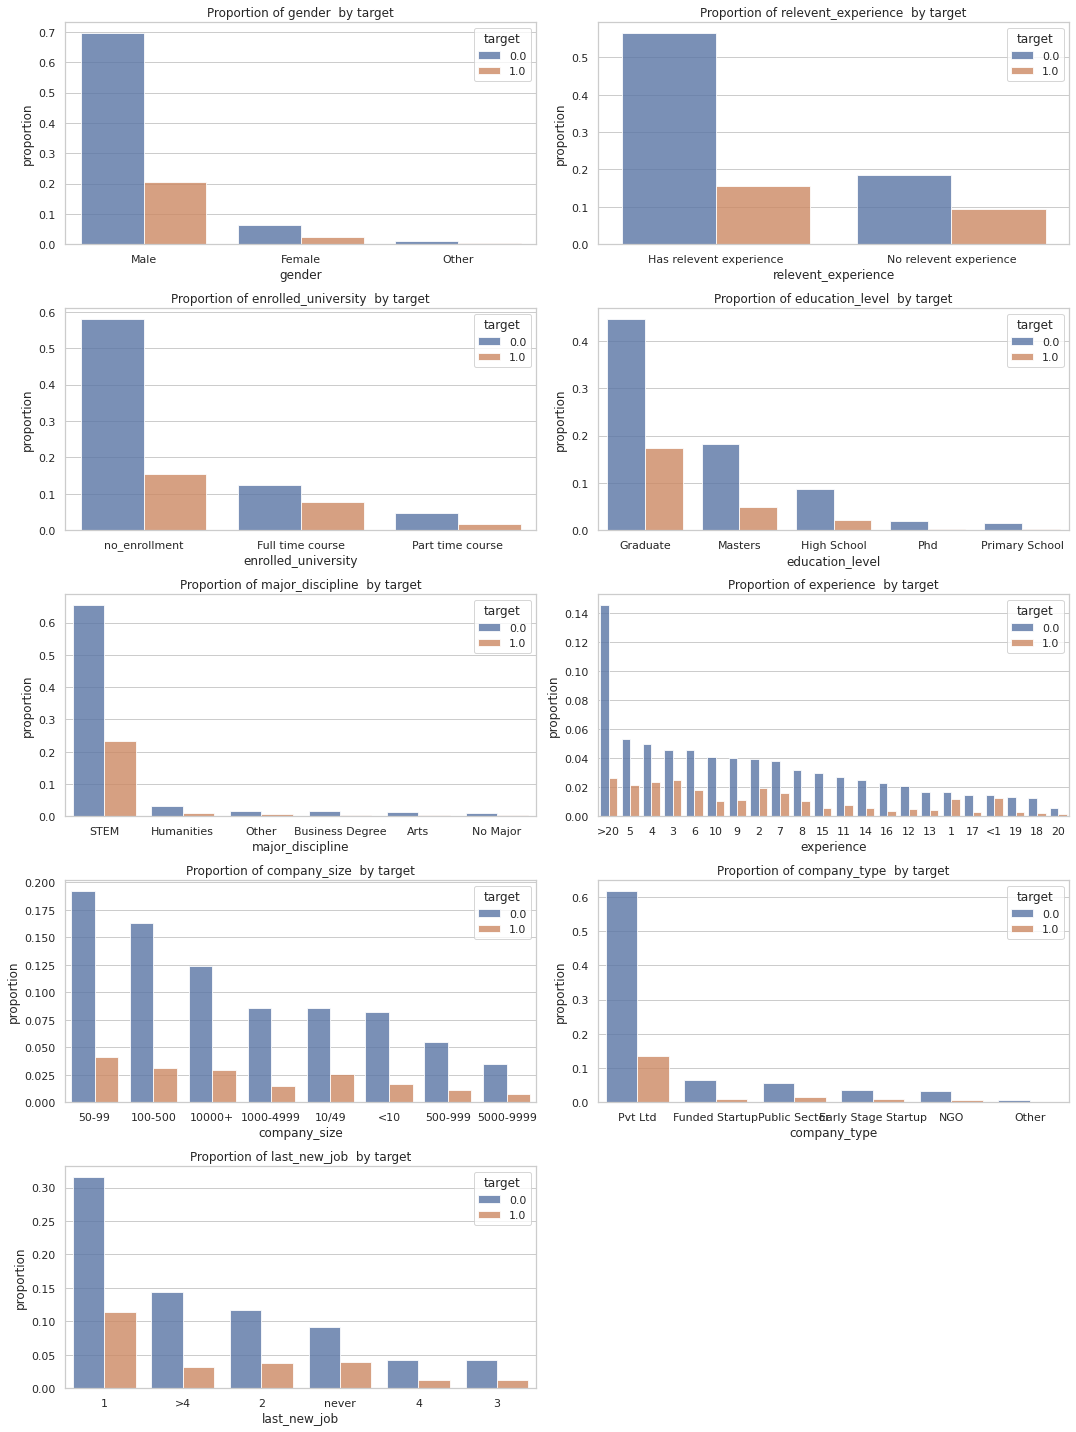

In [71]:
cols_obj = list(df_train.dtypes[df_train.dtypes == object].index[1:])

#plots the object type features against the target set value, and adjusts them to the dataset size
plt.figure(figsize=[15, 20])

i = 1
y, hue = 'proportion', 'target'

for f in cols_obj:
    plt.subplot(5, 2, i)
    df_train[[f, 'target']]\
        .value_counts(normalize=True)\
        .rename(y)\
        .reset_index()\
        .pipe((sns.barplot, 'data'), x=f, y='proportion', hue='target', alpha=0.8)
    plt.title('Proportion of {}  by target'.format(f))
    i += 1
plt.tight_layout()
plt.show()

The probability of the search for a new job is increasing with the following features:

- men
- working (no_enrollment)
- STEM background
- current company type PVT LTD (Private limited company, NAO)
- with 1 job experience

In [72]:
# null values
df_train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [73]:
def missing_values_table(df_train):
        mis_val = df_train.isnull().sum()
        
        mis_val_percent = 100 * df_train.isnull().sum() / len(df_train)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df_train.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [74]:
train_missing= missing_values_table(df_train)
train_missing

Your selected dataframe has 14 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
company_type,6140,32.0
company_size,5938,31.0
gender,4508,23.5
major_discipline,2813,14.7
education_level,460,2.4
last_new_job,423,2.2
enrolled_university,386,2.0
experience,65,0.3


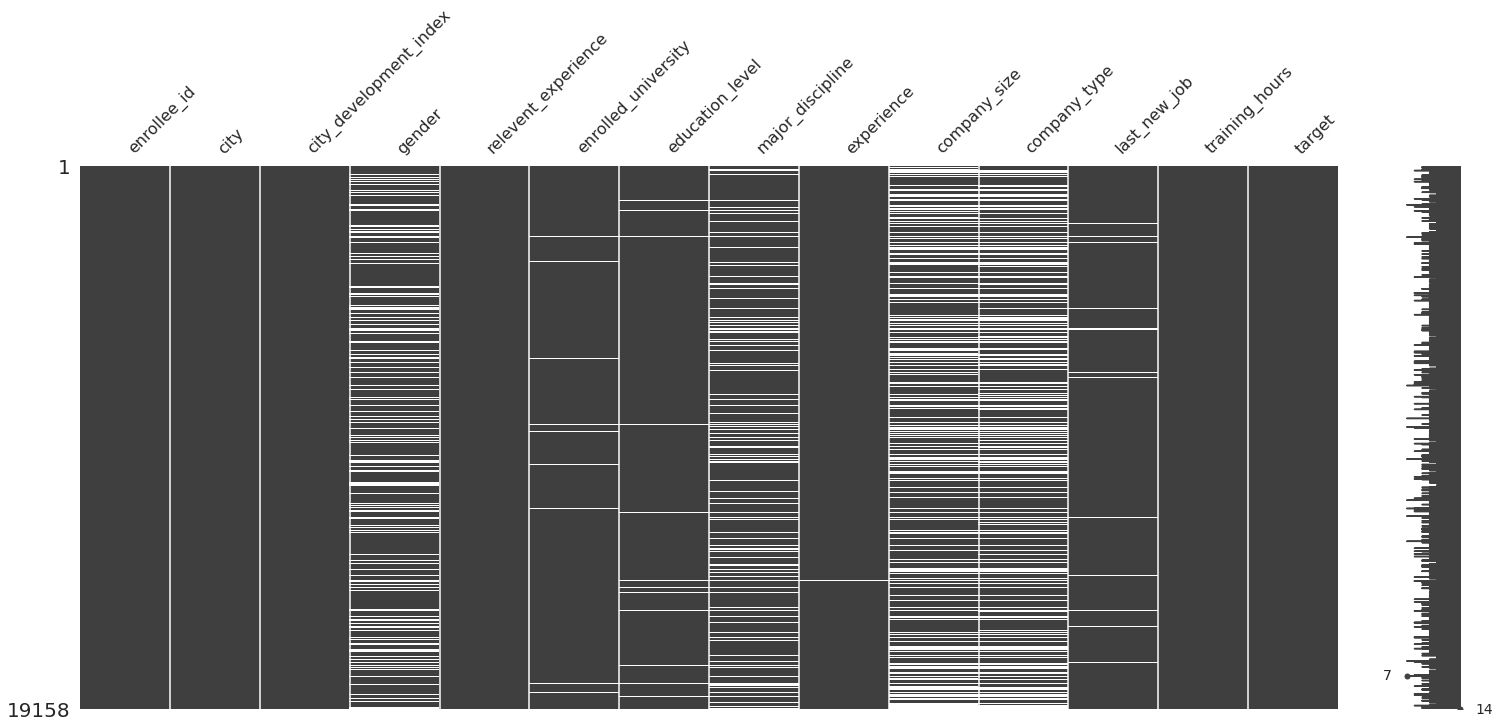

In [75]:
# generate preview of entries with null values
missingno.matrix(df_train)
plt.show()

In [76]:
if len(df_train[df_train.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(df_train[df_train.duplicated()]))
    print(df_train[df_train.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
else:
    print("No duplicated entries found")

No duplicated entries found


In our case, there are also no duplicated entries, which the code will point out directly by printing the output “No duplicated entries found”.<br>
In the event of duplicated entries, the output will show the number of duplicated entries and a preview of these entries.<br>
For duplicated entries, check that they are indeed duplicated and drop them by the following code:<br>
**df.drop_duplicates(inplace=True)**

# Feature Engineering

In this Notebook I am not going to use scikit-Learn LabelEncoder due to following reasons:

Label Encoder encode data on basis of count but this dataset has lots of ordinal features, which means categories of some features might depend upon some levels like in education_level feature.

We know that we should encode data in this order but label encoder encodes it on basis of count: 
Primary School High School Graduate Masters Phd

To use label encoder first we have to create NULL values as new category and Our data have so many NULL values so we can not just create new Category for NULL values because due to this data distribution could change.


**Various Approaches to Handle Missing values in Categorical Features**
 

1.   You can simply **drop columns** having very large amount of null values
2.   **Drop entire rows** if it has some null values. But this approach is not Recommendable because then we will lose lots of precious data)
3.   First convert none null categorical data into numarical form and then simply **fill mean, mode or median** value inplace of null values
4.   First convert none null categorical data into numarical form and then **with the help of k-Nearest Neighbors** algorithm find missing values and **impute** them in data
5.   Another way of imputing missing values in a column would be to **train a regression model that tries to predict missing values in a column based on other columns**.

In [96]:
#LabelEncoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

list_cols_non_numeric = ["education_level", "company_size", "company_type", "last_new_job", "major_discipline", "enrolled_university", "relevent_experience", "gender", "experience"]

for var in list_cols_non_numeric:
  df_train[var] = df_train[var].fillna("NaN")
  df_train[var] = le.fit_transform(df_train[var])

df_train.loc[:,'city'] = lb_en.fit_transform(df_train.loc[:,'city'])

df_train.drop(["enrollee_id"], axis=1)

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,5,0.920,1,0,3,0,6,21,8,3,0,36,1.0
1,77,0.776,1,1,3,0,6,6,4,6,4,47,0.0
2,64,0.624,2,1,0,0,6,15,8,3,6,83,0.0
3,14,0.789,2,1,1,0,1,20,8,6,6,52,1.0
4,50,0.767,1,0,3,2,6,21,4,1,3,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,55,0.878,1,1,3,0,2,5,8,3,0,42,1.0
19154,5,0.920,1,0,3,0,6,5,8,3,3,52,1.0
19155,5,0.920,1,0,3,0,6,21,4,6,3,44,0.0
19156,94,0.802,1,0,3,1,3,20,5,6,1,97,0.0


In [31]:
# Is manual mapping better than automatic mapping with a label encoder?
# Another approach would be to create a dictonary, define the new numerical categories and then map it to the columns
# 1) Making Dictionaries of ordinal features

gender_map = {
        'Female': 2,
        'Male': 1,
        'Other': 0
         }

relevent_experience_map = {
    'Has relevent experience':  1,
    'No relevent experience':   0
}

enrolled_university_map = {
    'no_enrollment'   :  0,
    'Full time course':  1, 
    'Part time course':  2 
}
    
education_level_map = {
    'Primary School' :    0,
    'Graduate'       :    2,
    'Masters'        :    3, 
    'High School'    :    1, 
    'Phd'            :    4
    } 
    
major_map ={ 
    'STEM'                   :    0,
    'Business Degree'        :    1, 
    'Arts'                   :    2, 
    'Humanities'             :    3, 
    'No Major'               :    4, 
    'Other'                  :    5 
}
    
experience_map = {
    '<1'      :    0,
    '1'       :    1, 
    '2'       :    2, 
    '3'       :    3, 
    '4'       :    4, 
    '5'       :    5,
    '6'       :    6,
    '7'       :    7,
    '8'       :    8, 
    '9'       :    9, 
    '10'      :    10, 
    '11'      :    11,
    '12'      :    12,
    '13'      :    13, 
    '14'      :    14, 
    '15'      :    15, 
    '16'      :    16,
    '17'      :    17,
    '18'      :    18,
    '19'      :    19, 
    '20'      :    20, 
    '>20'     :    21
} 
    
company_type_map = {
    'Pvt Ltd'               :    0,
    'Funded Startup'        :    1, 
    'Early Stage Startup'   :    2, 
    'Other'                 :    3, 
    'Public Sector'         :    4, 
    'NGO'                   :    5
}

company_size_map = {
    '<10'          :    0,
    '10/49'        :    1, 
    '100-500'      :    2, 
    '1000-4999'    :    3, 
    '10000+'       :    4, 
    '50-99'        :    5, 
    '500-999'      :    6, 
    '5000-9999'    :    7
}
    
last_new_job_map = {
    'never'        :    0,
    '1'            :    1, 
    '2'            :    2, 
    '3'            :    3, 
    '4'            :    4, 
    '>4'           :    5
}

In [32]:
# 2) using the map function to transform categorical features into numerical features (! Checking necessary : Kommazahlen statt ganze Zahlen !!!)


df_train.loc[:,'education_level'] = df_train['education_level'].map(education_level_map)
df_train.loc[:,'company_size'] = df_train['company_size'].map(company_size_map)
df_train.loc[:,'company_type'] = df_train['company_type'].map(company_type_map)
df_train.loc[:,'last_new_job'] = df_train['last_new_job'].map(last_new_job_map)
df_train.loc[:,'major_discipline'] = df_train['major_discipline'].map(major_map)
df_train.loc[:,'enrolled_university'] = df_train['enrolled_university'].map(enrolled_university_map)
df_train.loc[:,'relevent_experience'] = df_train['relevent_experience'].map(relevent_experience_map)
df_train.loc[:,'gender'] = df_train['gender'].map(gender_map)
df_train.loc[:,'experience'] = df_train['experience'].map(experience_map)

#encoding city feature using label encoder
lb_en = LabelEncoder()

df_train.loc[:,'city'] = lb_en.fit_transform(df_train.loc[:,'city']) 

In [35]:
df_train['gender'] = df_train['gender'].fillna((df_train['gender'].mean()))
df_train['enrolled_university'] = df_train['enrolled_university'].fillna((df_train['enrolled_university'].mean()))
df_train['major_discipline'] = df_train['major_discipline'].fillna((df_train['major_discipline'].mean()))
df_train['company_size'] = df_train['company_size'].fillna((df_train['company_size'].mean()))
df_train['company_type'] = df_train['company_type'].fillna((df_train['company_type'].mean()))
df_train['company_type'] = df_train['company_type'].fillna((df_train['company_type'].mean()))

In [36]:
# check for null values
df_train.isnull().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                      0
relevent_experience         0
enrolled_university         0
education_level           460
major_discipline            0
experience                 65
company_size                0
company_type                0
last_new_job              423
training_hours              0
target                      0
dtype: int64

In [37]:
train_missing= missing_values_table(df_train)
train_missing

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
education_level,460,2.4
last_new_job,423,2.2
experience,65,0.3


In [39]:
df_train.dtypes

enrollee_id                 int64
city                        int64
city_development_index    float64
gender                    float64
relevent_experience         int64
enrolled_university       float64
education_level           float64
major_discipline          float64
experience                float64
company_size              float64
company_type              float64
last_new_job              float64
training_hours              int64
target                    float64
dtype: object

In [40]:
# correlations
#Here I try to measure correlation in data using Correlation coefficients.

#Correlation coefficientsare used to measure how strong a relationship is between two variables.Correlation coefficient formulas are used to find how strong a relationship is between data. The formulas return a value between -1 and 1, where:

#1 indicates a strong positive relationship.
#-1 indicates a strong negative relationship.
#A result of zero indicates no relationship at all.

corr = df_train.corr()
print(corr)

                        enrollee_id      city  ...  training_hours    target
enrollee_id                1.000000 -0.011566  ...        0.000998  0.049475
city                      -0.011566  1.000000  ...        0.009537  0.056233
city_development_index    -0.040455 -0.326104  ...        0.001920 -0.341665
gender                     0.004615 -0.018939  ...        0.002229  0.015369
relevent_experience       -0.043359 -0.006154  ...        0.011566 -0.128430
enrolled_university        0.035751  0.078111  ...        0.003470  0.105280
education_level           -0.023288 -0.015137  ...       -0.011275 -0.011411
major_discipline           0.024781 -0.081184  ...       -0.001276 -0.013887
experience                -0.035509 -0.118830  ...        0.000908 -0.176724
company_size               0.006390 -0.040546  ...        0.003773 -0.006401
company_type               0.007267 -0.030443  ...        0.000360  0.018691
last_new_job              -0.030693 -0.077415  ...       -0.006276 -0.082607

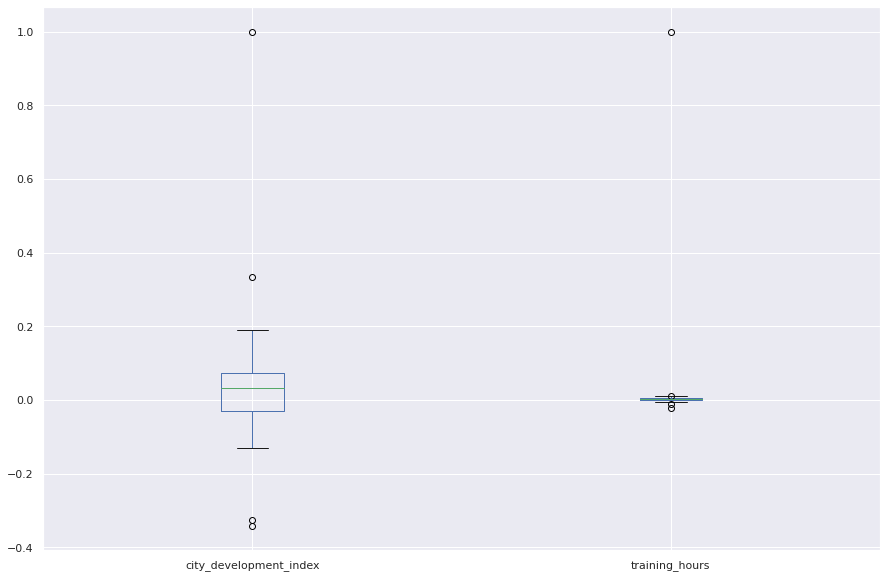

In [57]:
#plotting correlations

# prefer boxplot (ex.: city_devlopment_index, experience (numeric)) for each feature & barplot for company_type, education_level

# see tutorial seaborn.pydata.org/tutorial.html

var_numeric = ["city_development_index", "training_hours"]
var_non_numeric = ["company_type", "experience"]

df_train.corr()[var_numeric].plot.box(figsize = (15,10)) 


Text(0.5, 1.0, 'Correlation between features')

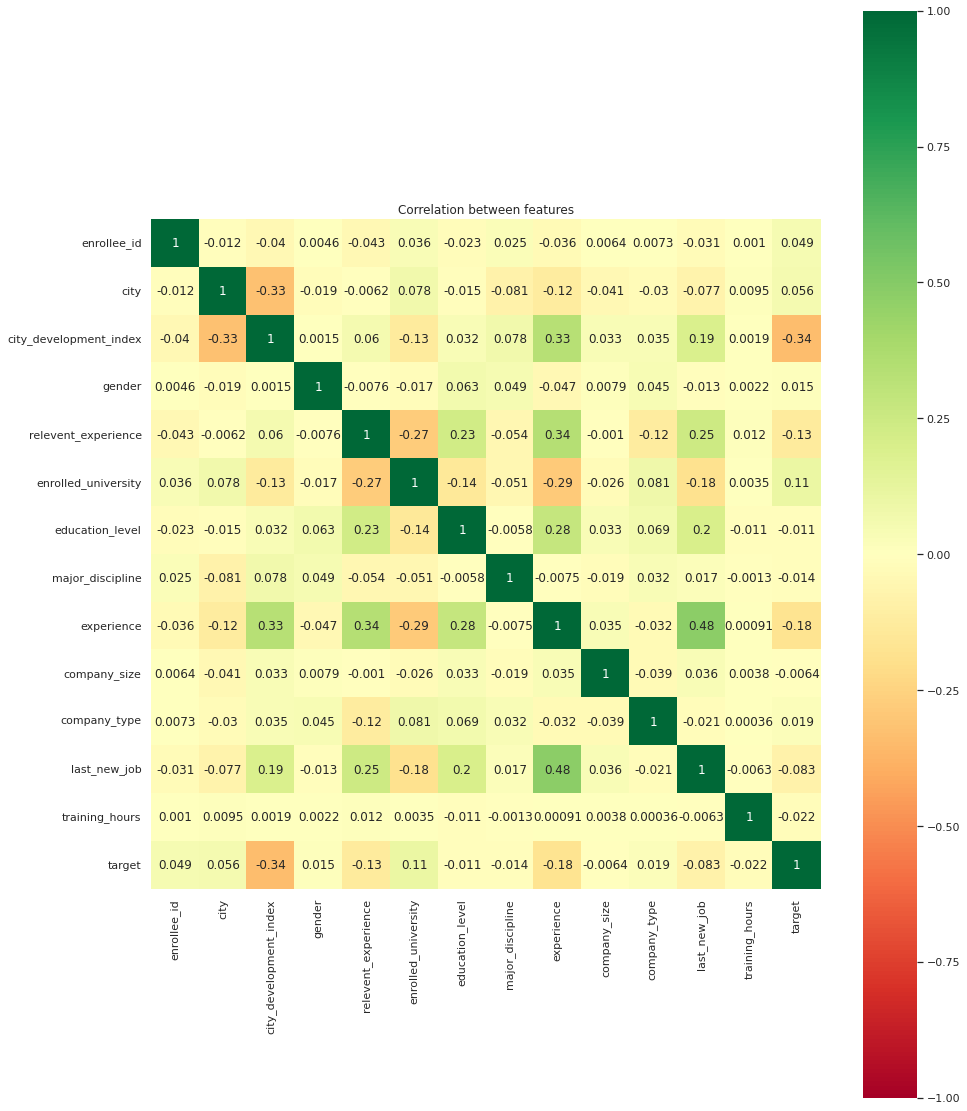

In [41]:
# heatmap

#define figure size
sns.set(rc={"figure.figsize":(15, 20)}) #width=15, height=20
#display heatmap
sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1, square=True, cmap="RdYlGn")
plt.title('Correlation between features')

In [28]:
# NEXT STEPS
# drop enrollee_id (+ city?) - done
# handle missing data in education_level + last_new_job + experience - done
# handle imbalanced data (upsampling?)

In [29]:
#Replace nan values with average of columns
df_train['education_level'] = df_train['education_level'].fillna((df_train['education_level'].mean()))
df_train['last_new_job'] = df_train['last_new_job'].fillna((df_train['last_new_job'].mean()))
df_train['experience'] = df_train['experience'].fillna((df_train['experience'].mean()))


df_train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1.000000,1,0.000000,2.0,0.000000,21.0,3.27466,0.690966,1.0,36,1.0
1,29725,77,0.776,1.000000,0,0.000000,2.0,0.000000,15.0,5.00000,0.000000,5.0,47,0.0
2,11561,64,0.624,1.071468,0,1.000000,2.0,0.000000,5.0,3.27466,0.690966,0.0,83,0.0
3,33241,14,0.789,1.071468,0,0.327775,2.0,1.000000,0.0,3.27466,0.000000,0.0,52,1.0
4,666,50,0.767,1.000000,1,0.000000,3.0,0.000000,21.0,5.00000,1.000000,4.0,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,55,0.878,1.000000,0,0.000000,2.0,3.000000,14.0,3.27466,0.690966,1.0,42,1.0
19154,31398,5,0.920,1.000000,1,0.000000,2.0,0.000000,14.0,3.27466,0.690966,4.0,52,1.0
19155,24576,5,0.920,1.000000,1,0.000000,2.0,0.000000,21.0,5.00000,0.000000,4.0,44,0.0
19156,5756,94,0.802,1.000000,1,0.000000,1.0,0.344876,0.0,6.00000,0.000000,2.0,97,0.0


In [30]:
train_missing= missing_values_table(df_train)
train_missing

Your selected dataframe has 14 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Test Dataset

In [31]:
#applying the same procedure on the test data set or rather combine from the beginning the training + test data set and split them while modeling?
# use train separately, apply to test set in parallel or aftewards, ex.: creating functions
# using only .fit --> only training dataset and .transform --> test set
# feature engineering after train_test_split

def missing_values_table(df_test):
        mis_val = df_test.isnull().sum()
        
        mis_val_percent = 100 * df_test.isnull().sum() / len(df_test)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df_test.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns


In [32]:
test_missing= missing_values_table(df_test)
test_missing

Your selected dataframe has 13 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
company_type,634,29.8
company_size,622,29.2
gender,508,23.9
major_discipline,312,14.7
education_level,52,2.4
last_new_job,40,1.9
enrolled_university,31,1.5
experience,5,0.2


In [33]:
df_test.loc[:,'education_level'] = df_test['education_level'].map(education_level_map)
df_test.loc[:,'company_size'] = df_test['company_size'].map(company_size_map)
df_test.loc[:,'company_type'] = df_test['company_type'].map(company_type_map)
df_test.loc[:,'last_new_job'] = df_test['last_new_job'].map(last_new_job_map)
df_test.loc[:,'major_discipline'] = df_test['major_discipline'].map(major_map)
df_test.loc[:,'enrolled_university'] = df_test['enrolled_university'].map(enrolled_university_map)
df_test.loc[:,'relevent_experience'] = df_test['relevent_experience'].map(relevent_experience_map)
df_test.loc[:,'gender'] = df_test['gender'].map(gender_map)
df_test.loc[:,'experience'] = df_test['experience'].map(experience_map)

#encoding city feature using label encoder
lb_en = LabelEncoder()

df_test.loc[:,'city'] = lb_en.fit_transform(df_test.loc[:,'city']) 

In [34]:
df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,69,0.827,1.0,1,1.0,2.0,0.0,9.0,0.0,NaN,1.0,21
1,9858,5,0.920,2.0,1,0.0,2.0,0.0,5.0,NaN,0.0,1.0,98
2,31806,55,0.624,1.0,0,0.0,1.0,NaN,0.0,NaN,0.0,0.0,15
3,27385,22,0.827,1.0,1,0.0,3.0,0.0,11.0,1.0,0.0,1.0,39
4,27724,5,0.920,1.0,1,0.0,2.0,0.0,21.0,4.0,0.0,5.0,72


In [35]:
# check for null values
df_test.isnull().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

In [36]:
df_test['gender'] = df_test['gender'].fillna((df_test['gender'].mean()))
df_test['enrolled_university'] = df_test['enrolled_university'].fillna((df_test['enrolled_university'].mean()))
df_test['education_level'] = df_test['education_level'].fillna((df_test['education_level'].mean()))
df_test['major_discipline'] = df_test['major_discipline'].fillna((df_test['major_discipline'].mean()))
df_test['experience'] = df_test['experience'].fillna((df_test['experience'].mean()))
df_test['company_size'] = df_test['company_size'].fillna((df_test['company_size'].mean()))
df_test['company_type'] = df_test['company_type'].fillna((df_test['company_type'].mean()))
df_test['company_type'] = df_test['company_type'].fillna((df_test['company_type'].mean()))
df_test['last_new_job'] = df_test['last_new_job'].fillna((df_test['last_new_job'].mean()))

In [37]:
df_test

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,69,0.827,1.0,1,1.0,2.0,0.000000,9.0,0.000000,0.692977,1.0,21
1,9858,5,0.920,2.0,1,0.0,2.0,0.000000,5.0,3.184472,0.000000,1.0,98
2,31806,55,0.624,1.0,0,0.0,1.0,0.329664,0.0,3.184472,0.000000,0.0,15
3,27385,22,0.827,1.0,1,0.0,3.0,0.000000,11.0,1.000000,0.000000,1.0,39
4,27724,5,0.920,1.0,1,0.0,2.0,0.000000,21.0,4.000000,0.000000,5.0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,5,0.920,1.0,0,0.0,2.0,3.000000,16.0,3.184472,4.000000,4.0,15
2125,195,25,0.897,1.0,1,0.0,3.0,0.000000,18.0,3.184472,0.692977,2.0,30
2126,31762,2,0.887,1.0,0,0.0,0.0,0.329664,3.0,3.184472,0.000000,0.0,18
2127,7873,4,0.804,1.0,1,1.0,1.0,0.329664,7.0,2.000000,4.000000,1.0,84


In [38]:
test_missing= missing_values_table(df_test)
test_missing

Your selected dataframe has 13 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Modelling

In [39]:
from sklearn.model_selection import train_test_split
Y = df_train['target']
X = df_train.drop(columns=['target'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=9)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


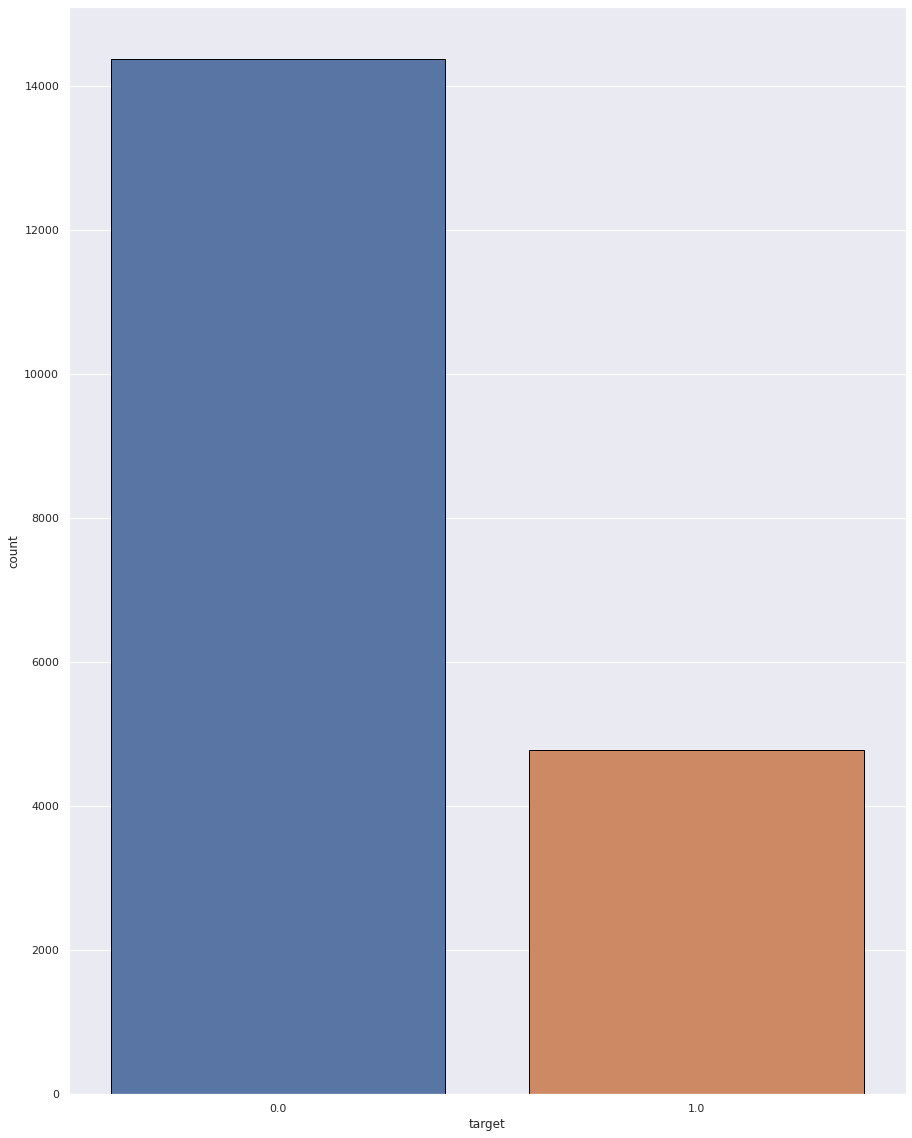

In [40]:
sns.countplot(df_train['target'], edgecolor = 'black')

We have an imbalanced dataset - there are many more non job-seekers than job-seekers.

In [41]:
# 

NameError: ignored

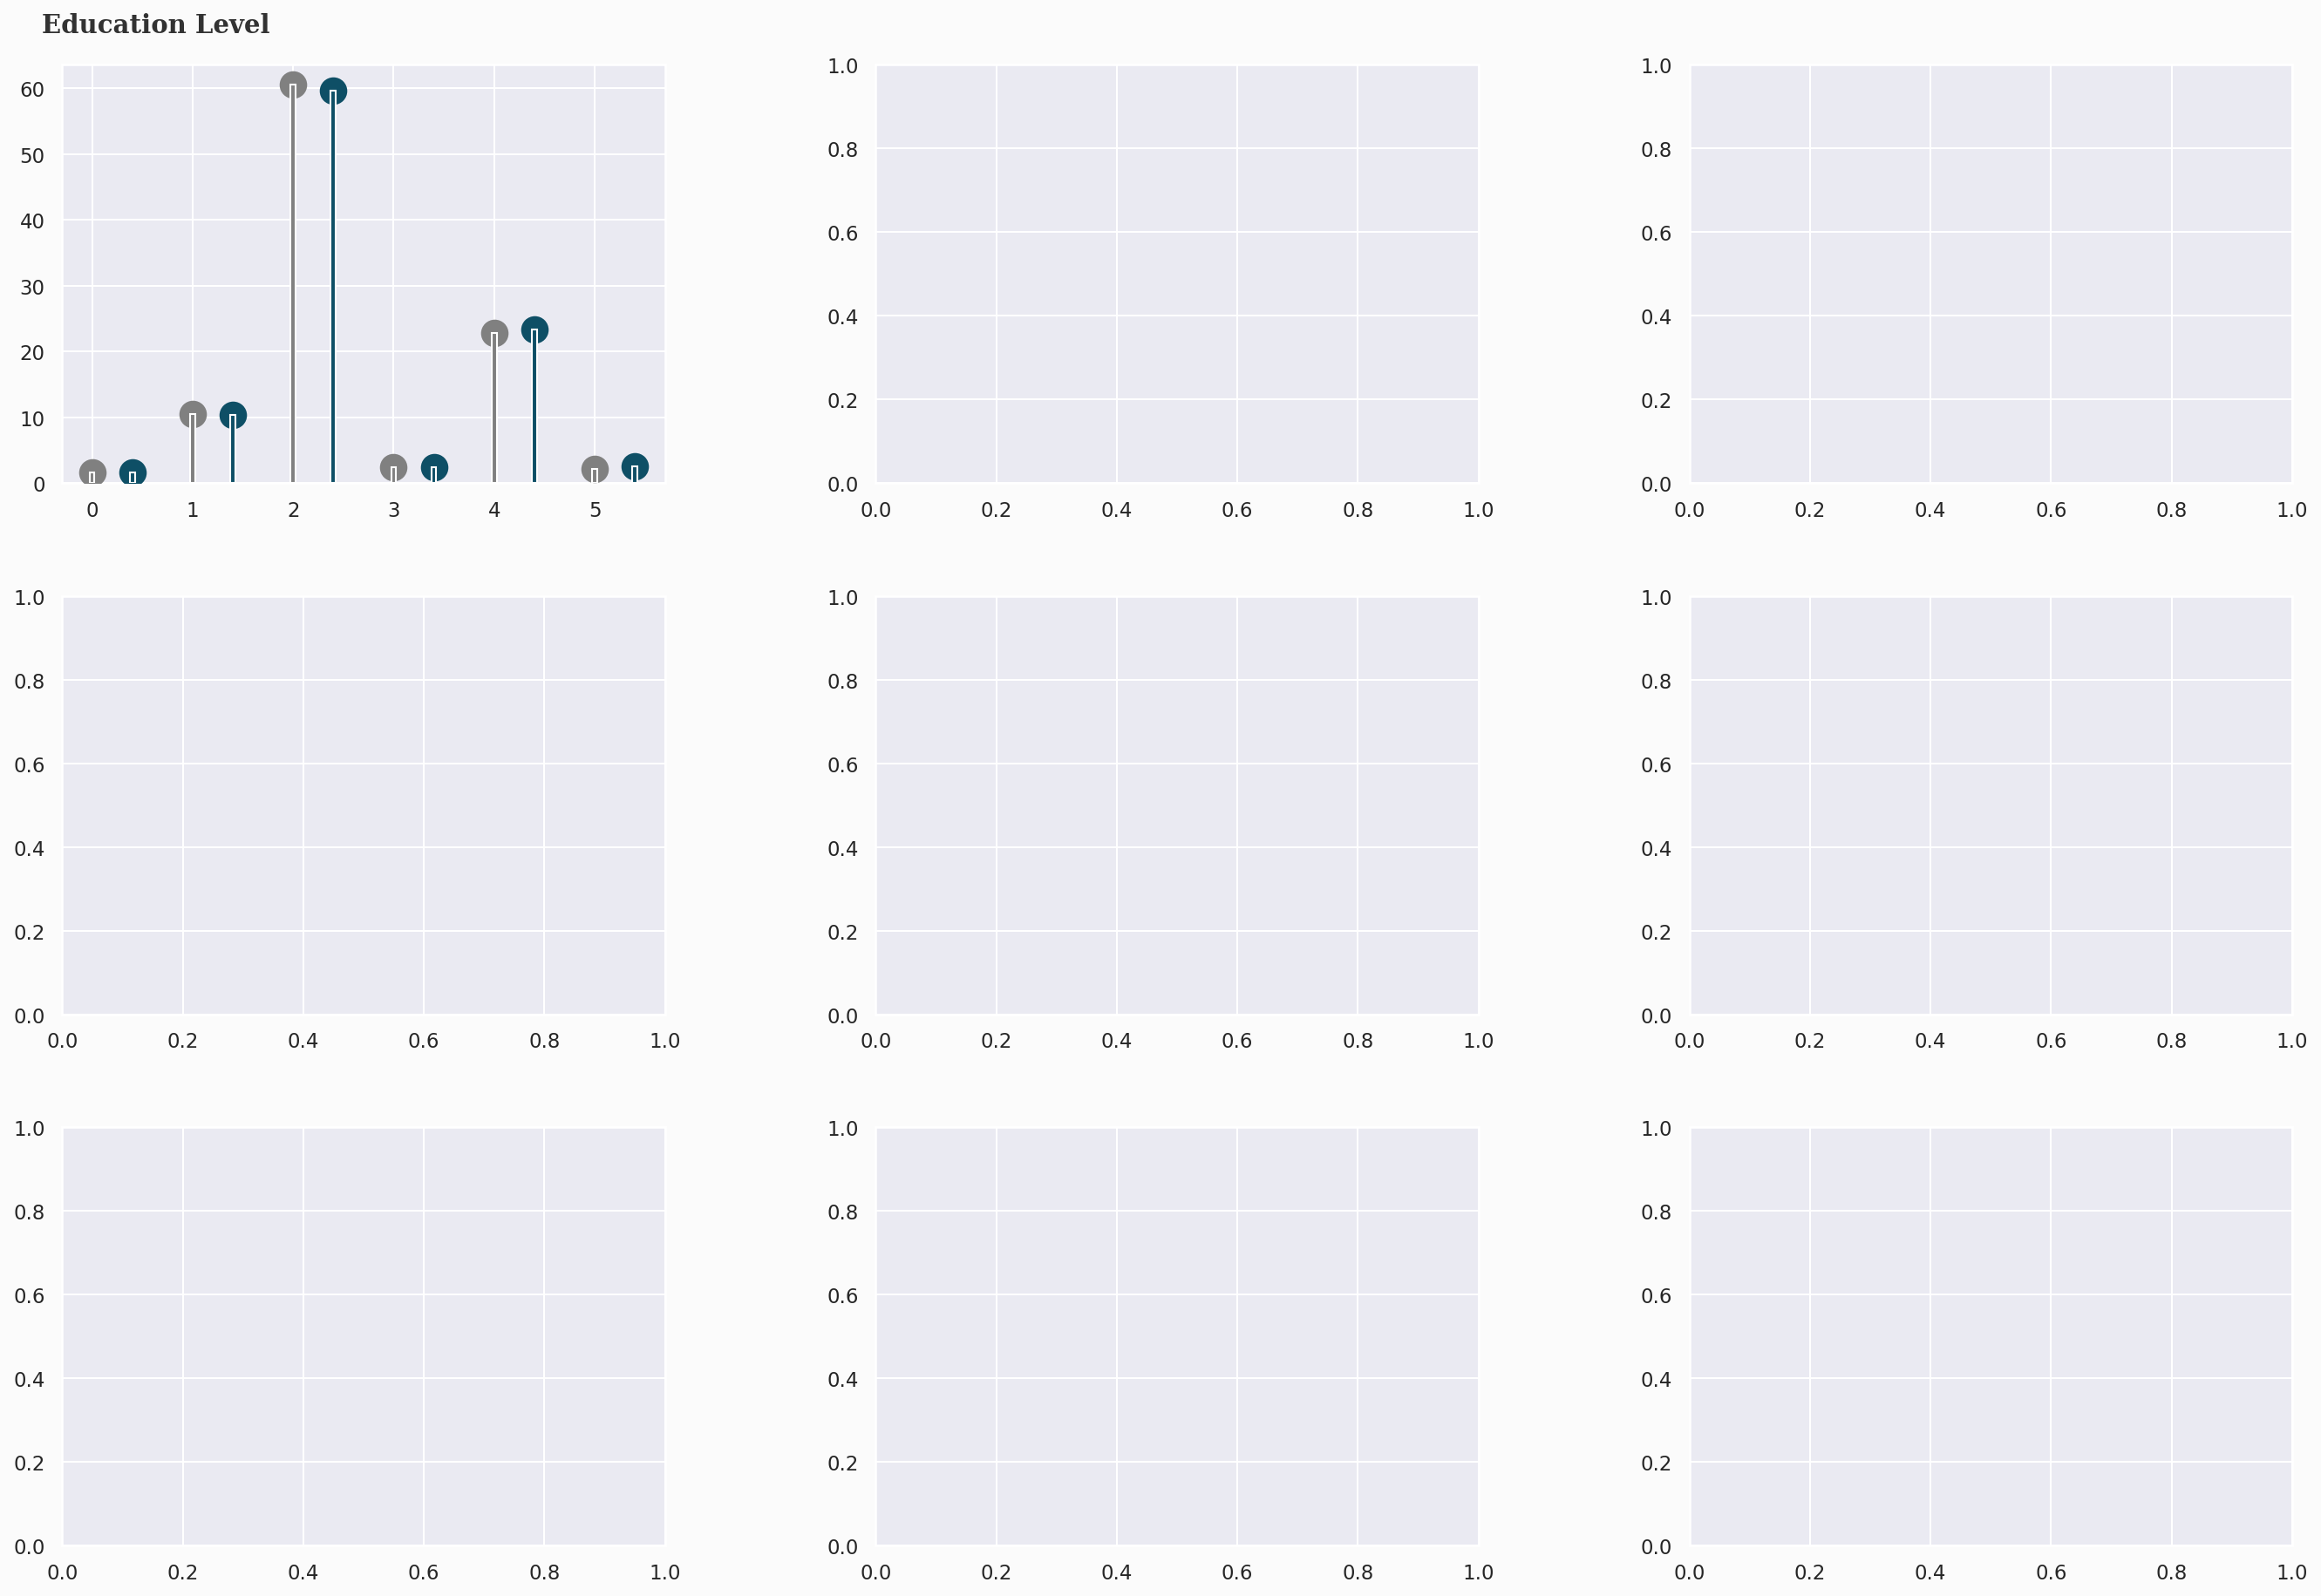

In [42]:
# Comparing the Train & Test set using GridSpec. It enables you to plot multiple plots and is highly customisable + you can convey a lot of information in a small amount of space.

background_color = "#fbfbfb"

fig = plt.figure(figsize=(22,15),dpi=150)
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])


# Ax0 - EDUCATION LEVEL
train = pd.DataFrame(df_train["education_level"].value_counts())
train["Percentage"] = train["education_level"].apply(lambda x: x/sum(train["education_level"])*100)
train = train.sort_index()

test = pd.DataFrame(df_test["education_level"].value_counts())
test["Percentage"] = test["education_level"].apply(lambda x: x/sum(test["education_level"])*100)
test = test.sort_index()

ax0.bar(np.arange(len(train.index)), height=train["Percentage"], zorder=3, color="gray", width=0.05)
ax0.scatter(np.arange(len(train.index)), train["Percentage"], zorder=3,s=200, color="gray")
ax0.bar(np.arange(len(test.index))+0.4, height=test["Percentage"], zorder=3, color="#0e4f66", width=0.05)
ax0.scatter(np.arange(len(test.index))+0.4, test["Percentage"], zorder=3,s=200, color="#0e4f66")
ax0.text(-0.5, 68.5, 'Education Level', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax0.yaxis.set_major_formatter(mtick.PercentFormatter())
ax0.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax0.set_xticks(np.arange(len(train.index))+0.4 / 2)
ax0.set_xticklabels(list(train.index),rotation=0)


# Ax1 - ENROLLED IN UNIVESITY
train = pd.DataFrame(df_train["enrolled_university"].value_counts())
train["Percentage"] = train["enrolled_university"].apply(lambda x: x/sum(train["enrolled_university"])*100).loc[enroll_order]
test = pd.DataFrame(df_test["enrolled_university"].value_counts())
test["Percentage"] = test["enrolled_university"].apply(lambda x: x/sum(test["enrolled_university"])*100).loc[enroll_order]

ax1.text(0, 2.5, 'University Enrollment', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax1.barh(train.index, train['Percentage'], color="gray", zorder=3, height=0.6)
ax1.barh(test.index, test['Percentage'], color="#0e4f66", zorder=3, height=0.4)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))

###
# Ax2 - GENDER 
train = pd.DataFrame(df_train["gender"].value_counts())
train["Percentage"] = train["gender"].apply(lambda x: x/sum(train["gender"])*100)
test = pd.DataFrame(df_test["gender"].value_counts())
test["Percentage"] = test["gender"].apply(lambda x: x/sum(test["gender"])*100)

x = np.arange(len(train))
ax2.text(-0.6, 76, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=train["Percentage"], zorder=3, color="gray", width=0.4)
ax2.bar(x+0.4, height=test["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Male','Female','Other','Not provided'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], train["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], test["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    

    
## Ax 3 - CDI

ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
train = pd.DataFrame(df_train["city_development_index"])
test = pd.DataFrame(df_test["city_development_index"])
sns.kdeplot(train["city_development_index"], ax=ax3,color="gray", shade=True, label="Train")
sns.kdeplot(test["city_development_index"], ax=ax3, color="#0e4f66", shade=True, label="Test")
ax3.text(0.29, 13, 'City Development Index', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax3.set_ylabel('')    
ax3.set_xlabel('')

## AX4 - TITLE

ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.text(0.5, 0.6, 'How do our\n\n datasets compare?', horizontalalignment='center', verticalalignment='center',fontsize=22, fontweight='bold', fontfamily='serif', color="#323232")
ax4.text(0.28,0.57,"Train", fontweight="bold", fontfamily='serif', fontsize=22, color='gray')
ax4.text(0.5,0.57,"&", fontweight="bold", fontfamily='serif', fontsize=22, color='#323232')
ax4.text(0.58,0.57,"Test", fontweight="bold", fontfamily='serif', fontsize=22, color='#0e4f66')




### Ax5 - RELEVANT EXPERIENCE
train = pd.DataFrame(df_train["relevent_experience"].value_counts())
train["Percentage"] = train["relevent_experience"].apply(lambda x: x/sum(train["relevent_experience"])*100)
test = pd.DataFrame(df_test["relevent_experience"].value_counts())
test["Percentage"] = test["relevent_experience"].apply(lambda x: x/sum(test["relevent_experience"])*100)
x = np.arange(len(train))
ax5.text(-0.4, 80, 'Relevant Experience', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax5.bar(x, height=train["Percentage"], zorder=3, color="gray", width=0.4)
ax5.bar(x+0.4, height=test["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax5.set_xticks(x + 0.4 / 2)
ax5.set_xticklabels(['No relevant experience','Has relevant experience'])
ax5.yaxis.set_major_formatter(mtick.PercentFormatter())
ax5.yaxis.set_major_locator(mtick.MultipleLocator(10))

for i,j in zip([0, 1, 2], train["Percentage"]):
    ax5.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1, 2], test["Percentage"]):
    ax5.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

    
    
# Ax6 - TRAINING HOURS
train = pd.DataFrame(df_train["training_hours"])
train["TrainTest"] = "Train"
test = pd.DataFrame(df_test["training_hours"])
test["TrainTest"] = "Test"
ax6.text(-0.65, 370, 'Training Hours', fontsize=14, fontweight='bold', fontfamily='serif', color="#002d1d")
comb_graph_temp_df = pd.concat([train, test], axis=0)
sns.boxenplot(ax=ax6, y="training_hours", x="TrainTest", data=comb_graph_temp_df, palette=["gray", "#0e4f66"])
ax6.set_xlabel("")
ax6.set_ylabel("")


# Ax7 - EXPERIENCE YRS
train = pd.DataFrame(df_train["experience"].value_counts())
train["Percentage"] = train["experience"].apply(lambda x: x/sum(train["experience"])*100)
train = train.sort_index()
test = pd.DataFrame(df_test["experience"].value_counts())
test["Percentage"] = round(test["experience"].apply(lambda x: x/sum(test["experience"])*100),).astype(int)
test = test.sort_index()
ax7.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax7.plot(train.index, train["Percentage"], zorder=3, color="gray", marker='o')
ax7.plot(test.index, test["Percentage"], zorder=3, color="#0e4f66", marker='o')
ax7.text(-1.5, 20.5, 'Years Experience', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax7.set_yticklabels(labels = ['0   ', '5%','10%','15%'])
ax7.xaxis.set_major_locator(mtick.MultipleLocator(5))
ax7.yaxis.set_major_locator(mtick.MultipleLocator(5))


# Ax8 - MAJOR DISCIPLINE
train = pd.DataFrame(df_train["major_discipline"].value_counts())
train["Percentage"] = train["major_discipline"].apply(lambda x: x/sum(train["major_discipline"])*100)
test = pd.DataFrame(df_test["major_discipline"].value_counts())
test["Percentage"] = test["major_discipline"].apply(lambda x: x/sum(test["major_discipline"])*100)

ax8.barh(np.arange(len(train.index)), train["Percentage"], zorder=3, color="gray", height=0.4)
ax8.barh(np.arange(len(test.index))+0.4, test["Percentage"], zorder=3, color="#0e4f66", height=0.4)
ax8.text(-5, -0.8, 'Major Discipline', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.xaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(1))
ax8.set_yticks(np.arange(len(test.index))+0.4 / 2)
ax8.set_yticklabels(list(test.index))
ax8.invert_yaxis()



for i in range(0,9):
    locals()["ax"+str(i)].set_facecolor(background_color) 
    
for i in range(0,9):
    locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)


for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)

plt.show()

In [43]:
df_train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1.000000,1,0.000000,2.0,0.000000,21.0,3.27466,0.690966,1.0,36,1.0
1,29725,77,0.776,1.000000,0,0.000000,2.0,0.000000,15.0,5.00000,0.000000,5.0,47,0.0
2,11561,64,0.624,1.071468,0,1.000000,2.0,0.000000,5.0,3.27466,0.690966,0.0,83,0.0
3,33241,14,0.789,1.071468,0,0.327775,2.0,1.000000,0.0,3.27466,0.000000,0.0,52,1.0
4,666,50,0.767,1.000000,1,0.000000,3.0,0.000000,21.0,5.00000,1.000000,4.0,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,55,0.878,1.000000,0,0.000000,2.0,3.000000,14.0,3.27466,0.690966,1.0,42,1.0
19154,31398,5,0.920,1.000000,1,0.000000,2.0,0.000000,14.0,3.27466,0.690966,4.0,52,1.0
19155,24576,5,0.920,1.000000,1,0.000000,2.0,0.000000,21.0,5.00000,0.000000,4.0,44,0.0
19156,5756,94,0.802,1.000000,1,0.000000,1.0,0.344876,0.0,6.00000,0.000000,2.0,97,0.0


In [ ]:
#pip install -U imbalanced-learn

In [44]:

feature_columns = ["city_development_index", "gender", "relevent_experience", "enrolled_university", "education_level", "major_discipline", "experience", "company_size", "company_type","last_new_job",	"training_hours"]


In [45]:
from imblearn.over_sampling import SMOTE

In [47]:
oversample = SMOTE()
X, y = oversample.fit_resample(df_train[feature_columns], df_train['target'])

In [48]:
type(y)

pandas.core.series.Series

In [50]:
y.value_counts()

0.0    14381
1.0    14381
Name: target, dtype: int64

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [ ]:
# template / function:
#k means clustering
# k-nearest neighbors
# decision tree
# logistic regression
# ... --> print scores + compare
#gridsearch --> hyperparameter tuning